# SMS data

# Loading data

In [151]:
import pandas as pd

sms = pd.read_csv("data/sms_train.csv", sep=',')
sms.columns = ['label', 'message']

In [152]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        3959   3730                             Sorry, I'll call later   26
1         613    552  Please call our customer service representativ...    4

Training dataset is not balanced - balanced accuracy score will be helpful here.

### Cleaning, stemming and counting words

In [153]:
import re
import string
import nltk
stemmer = nltk.SnowballStemmer("english")

In [154]:
## this cell has been copied from: 
## https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained


# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = ' '.join(stemmer.stem(word) for word in text.split(' '))
    return text

sms['message_clean'] = sms['message'].apply(clean_text)

In [155]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(sms['message_clean'], 
                                                    sms['label'],
                                                    test_size=0.2,
                                                    random_state=0)
X_test = pd.read_csv("data/sms_test.csv", sep=',')
X_test.columns = ['message']
X_test['message_clean'] = X_test['message'].apply(clean_text)

In [156]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer()
vect.fit(X_train)
word_to_id_df = pd.DataFrame([{'label':k, 'id':i} for k, i in vect.vocabulary_.items()])
word_to_id_df = word_to_id_df.sort_values(by='id').reset_index(drop=True)
def encode_dataset(X, words_to_ids):
    X_transformed = vect.transform(X)
    X_encoded = pd.DataFrame(X_transformed.toarray(), columns=words_to_ids['label'])
    X_encoded.columns.name = ''
    return X_encoded
X_train_encoded = encode_dataset(X_train, word_to_id_df)
X_valid_encoded = encode_dataset(X_valid, word_to_id_df)
X_test_encoded = encode_dataset(X_test['message_clean'], word_to_id_df)

In [157]:
X_train_encoded.head()

,aa,aah,aaniy,aaooooright,aathilov,aathiwher,ab,abdomen,abeg,abelu,...,zebra,zed,zhong,zindgi,zoe,zogtorius,zoom,zyada,üll,〨ud
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Feature selection

## Boruta

In [158]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=7, random_state=42, class_weight='balanced', n_jobs=-1)
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=42, verbose=0)
import numpy as np
np.int = int
np.float = float
np.bool = bool
feat_selector.fit(X_train_encoded.values, y_train)
print(f'Number of features selected: {feat_selector.n_features_}')
X_train_filtered = feat_selector.transform(X_train_encoded.values)
X_valid_filtered = feat_selector.transform(X_valid_encoded.values)
X_test_filtered = feat_selector.transform(X_test_encoded.values)

Number of features selected: 132


In [159]:
# print names of selected features
selected_features = X_train_encoded.columns[feat_selector.support_].values.tolist()
print(f'Selected {len(selected_features)} features: {selected_features}')

Selected 132 features: ['admir', 'and', 'appli', 'at', 'attempt', 'await', 'award', 'bonus', 'box', 'but', 'call', 'camera', 'can', 'cash', 'chanc', 'chat', 'claim', 'club', 'code', 'collect', 'come', 'contact', 'cost', 'credit', 'custom', 'date', 'do', 'draw', 'eg', 'entri', 'everi', 'for', 'free', 'from', 'game', 'get', 'go', 'got', 'guarante', 'have', 'he', 'holiday', 'hot', 'how', 'if', 'ill', 'im', 'in', 'is', 'it', 'know', 'landlin', 'later', 'latest', 'like', 'line', 'love', 'ltd', 'ltgt', 'me', 'messag', 'min', 'mob', 'mobil', 'music', 'my', 'network', 'new', 'nokia', 'not', 'now', 'number', 'offer', 'ok', 'on', 'onli', 'or', 'orang', 'our', 'out', 'per', 'phone', 'pic', 'pleas', 'po', 'poli', 'pound', 'prize', 'rate', 'receiv', 'repli', 'rington', 'rreveal', 'sae', 'select', 'send', 'servic', 'sms', 'so', 'sorri', 'specialcal', 'stop', 'tc', 'tcs', 'text', 'that', 'the', 'this', 'to', 'tone', 'tscs', 'txt', 'ufind', 'uk', 'unsubscrib', 'ur', 'urgent', 'valid', 'video', 'vouche

### Naive Bayes vs correlation threshold

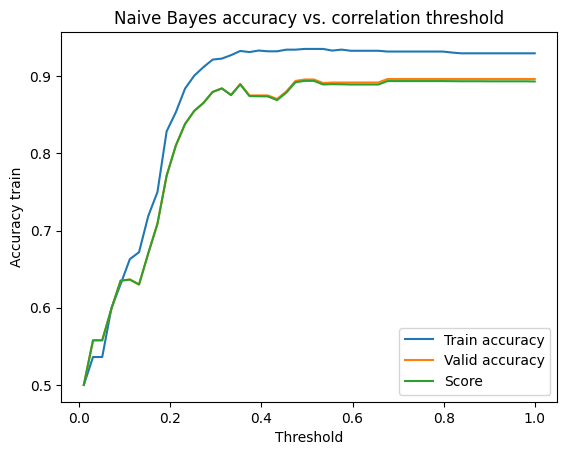

Best threshold: 0.5151


In [160]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_accuracy_for_threshold(threshold):

    corr_matrix = pd.DataFrame(X_train_filtered, columns=selected_features).corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    X_train_filtered_small = pd.DataFrame(X_train_filtered, columns=selected_features).drop(to_drop, axis=1)
    X_valid_filtered_small = pd.DataFrame(X_valid_filtered, columns=selected_features).drop(to_drop, axis=1)

    nb = MultinomialNB()
    nb.fit(X_train_filtered_small, y_train)
    y_pred_train = nb.predict(X_train_filtered_small)
    balanced_acc_train = balanced_accuracy_score(y_train, y_pred_train)
    y_pred_valid = nb.predict(X_valid_filtered_small)
    balanced_acc_valid = balanced_accuracy_score(y_valid, y_pred_valid)
    score = balanced_acc_valid - 0.01 * max(X_train_filtered_small.shape[1] / 100 - 1, 0)

    return {'Threshold': threshold, 'Accuracy train': balanced_acc_train, 'Accuracy valid': balanced_acc_valid, 'Score': score}

thresholds = np.linspace(0.01, 1, 50)
results = pd.DataFrame([get_accuracy_for_threshold(t) for t in thresholds])
sns.lineplot(x='Threshold', y='Accuracy train', data=results, label='Train accuracy')
sns.lineplot(x='Threshold', y='Accuracy valid', data=results, label='Valid accuracy')
sns.lineplot(x='Threshold', y='Score', data=results, label='Score')
plt.title('Naive Bayes accuracy vs. correlation threshold')
plt.show()

print(f'Best threshold: {results.sort_values(by="Score", ascending=False).iloc[0]["Threshold"]:0.4f}')

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

best_threshold = results.sort_values(by="Score", ascending=False).iloc[0]["Threshold"]
corr_matrix = pd.DataFrame(X_train_filtered, columns=selected_features).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > best_threshold)]
X_train_filtered_small = pd.DataFrame(X_train_filtered, columns=selected_features).drop(to_drop, axis=1)
X_valid_filtered_small = pd.DataFrame(X_valid_filtered, columns=selected_features).drop(to_drop, axis=1)
X_test_filtered_small = pd.DataFrame(X_test_filtered, columns=selected_features).drop(to_drop, axis=1)
print(f'Number of features after dropping: {X_train_filtered_small.shape[1]}')
selected_features_final = X_train_filtered_small.columns.values.tolist()
print(f'Features after filtering: {selected_features_final}')

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_filtered_small, y_train)
y_pred = nb.predict(X_valid_filtered_small)
from sklearn.metrics import balanced_accuracy_score
print(f'Balanced accuracy score: {balanced_accuracy_score(y_valid, y_pred):.4f}')

Number of features after dropping: 118
Features after filtering: ['admir', 'and', 'appli', 'at', 'attempt', 'await', 'award', 'bonus', 'box', 'but', 'call', 'camera', 'can', 'cash', 'chanc', 'chat', 'claim', 'club', 'code', 'come', 'contact', 'cost', 'credit', 'custom', 'date', 'do', 'draw', 'eg', 'entri', 'everi', 'for', 'free', 'from', 'game', 'get', 'go', 'got', 'guarante', 'have', 'he', 'hot', 'how', 'if', 'ill', 'im', 'in', 'is', 'it', 'know', 'landlin', 'later', 'latest', 'like', 'line', 'love', 'ltd', 'ltgt', 'me', 'messag', 'min', 'mob', 'mobil', 'music', 'my', 'network', 'new', 'nokia', 'not', 'now', 'number', 'offer', 'ok', 'on', 'onli', 'or', 'our', 'out', 'per', 'phone', 'pic', 'pleas', 'poli', 'pound', 'rate', 'receiv', 'repli', 'rington', 'send', 'servic', 'sms', 'so', 'sorri', 'stop', 'tc', 'text', 'that', 'the', 'this', 'to', 'tone', 'tscs', 'txt', 'uk', 'unsubscrib', 'ur', 'urgent', 'video', 'voucher', 'was', 'week', 'when', 'win', 'with', 'wkli', 'word', 'work', 'you'

# Saving predictions